# Importing dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import pickle
from IPython.display import Markdown, display
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
)


# Creating functions

In [3]:
## printing the shape and head
def head(df,shape_only=False):
    print(df.shape)

    if shape_only:
        return
    else:
        return df.head()

## for EDA of categorical values
def eda_bivariate_categorical(df,column,target):

    fig,ax = plt.subplots(figsize = (9,8))

    color = 'Set2'

    palette_color = sns.color_palette(color)

    ax = sns.countplot(x = column, data=df, hue=target,palette=color,order = df[column].value_counts().index)
    ax.set_ylabel('Count')

    offset = df[column].value_counts().max() * 0.005

    list_bars = df.groupby([column,target])[column].agg(['count']).unstack().fillna(0).values

    patches = ax.patches
    bars_pos = 0

    for i in range(df[target].nunique()):
        for j in range(df[column].nunique()):
            list_bars_col = list_bars[j]
            total_sum = list_bars_col.sum()
            value = list_bars_col[i]

            percentage = value / total_sum

            if percentage == 0:
                bars_pos += 1
                continue
            else:
                x = patches[bars_pos].get_x() + patches[j].get_width()/2
                y = patches[bars_pos].get_height() + offset
                ax.annotate('{:.1f}%'.format(percentage*100), (x, y), ha='center')
                bars_pos += 1
    plt.show()

## Function that plots numerical variables into histogram and violin plot
def eda_bivariate_numerical(data,column,target,color,
                    figsize=(12,6),
                    # save=True,
                    val=0,
                    target_type = 'Numerical'):

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    cmap = sns.color_palette(color)
    val = val

    for i in range(1):
        for j in range(2):
            if j==0:
                    sns.histplot(data = data,x=data[column],hue=target,
                                bins=50,kde=True,palette=color,ax=axes[j])
                    axes[j].set(xlabel=None)
                    axes[j].grid(False)
            elif j==1:
                sns.boxplot(data = data,x=data[column],y = target, ax=axes[j], palette=color,orient='h',
                )
                axes[j].set(xlabel=None)
                axes[j].grid(False)
                val += 1
                plt.tight_layout()
            if target_type == 'Numerical':
                plt.suptitle(column)
            else:
                plt.suptitle(f'{column} vs. {target}')
    plt.show()

    # path = 'Figures\\Numerical\\'
    # if save:
    #     plt.savefig(f"{path}{column}.pdf",dpi=1000)


## print text to see the font
def print_text(text):
    fig, ax = plt.subplots(figsize=(6, 1), facecolor="#eefade")
    ax.text(0.5, 0.5, text, ha='center', va='center', size=40)
    ax.axis("off")
    plt.show()


# Reading dataset and showing its descriptions

In [4]:
df = pd.read_csv('./CVD_cleaned.csv')

## Viewing the dataframe and shape
head(df,shape_only=False)

(308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [5]:
## Setting the target variable
target = 'Heart_Disease'

In [6]:
## Creating numerical and categorical columns
numerical = df.select_dtypes(include=['float64']).columns.sort_values()
categorical = df.select_dtypes(include=['object']).columns.sort_values()

## Printing the length of numerical and categorical. The total length should have
## the same length as our dataframe
print(f'There are {len(categorical)} Categorical variables')
print(f'There are {len(numerical)} Numerical variables')

There are 12 Categorical variables
There are 7 Numerical variables


In [7]:
## Showing the columns in alphabetical order
df.columns.sort_values()

## Showing the descriptions of numerical variables
print('')
num_describe = df.describe().T
num_describe_table = num_describe.loc[:,['mean', 'std', '25%', '50%', '75%']]
print(num_describe_table)

## Showing the descriptions of categorical variables
print('')
object_describe_table = df.describe(include=object)
print(object_describe_table)
## print it to latex
# print(object_describe_table.to_latex())


                                    mean        std     25%     50%     75%
Height_(cm)                   170.615249  10.658026  163.00  170.00  178.00
Weight_(kg)                    83.588655  21.343210   68.04   81.65   95.25
BMI                            28.626211   6.522323   24.21   27.44   31.85
Alcohol_Consumption             5.096366   8.199763    0.00    1.00    6.00
Fruit_Consumption              29.835200  24.875735   12.00   30.00   30.00
Green_Vegetables_Consumption   15.110441  14.926238    4.00   12.00   20.00
FriedPotato_Consumption         6.296616   8.582954    2.00    4.00    8.00



       General_Health               Checkup Exercise Heart_Disease  \
count          308854                308854   308854        308854   
unique              5                     5        2             2   
top         Very Good  Within the past year      Yes            No   
freq           110395                239371   239381        283883   

       Skin_Cancer Other_Cancer Depression Diabetes Arthritis     Sex  \
count       308854       308854     308854   308854    308854  308854   
unique           2            2          2        4         2       2   
top             No           No         No       No        No  Female   
freq        278860       278976     246953   259141    207783  160196   

       Age_Category Smoking_History  
count        308854          308854  
unique           13               2  
top           65-69              No  
freq          33434          183590  


# Exploratory Data Analysis (EDA)

## Target Variable

### Categorical

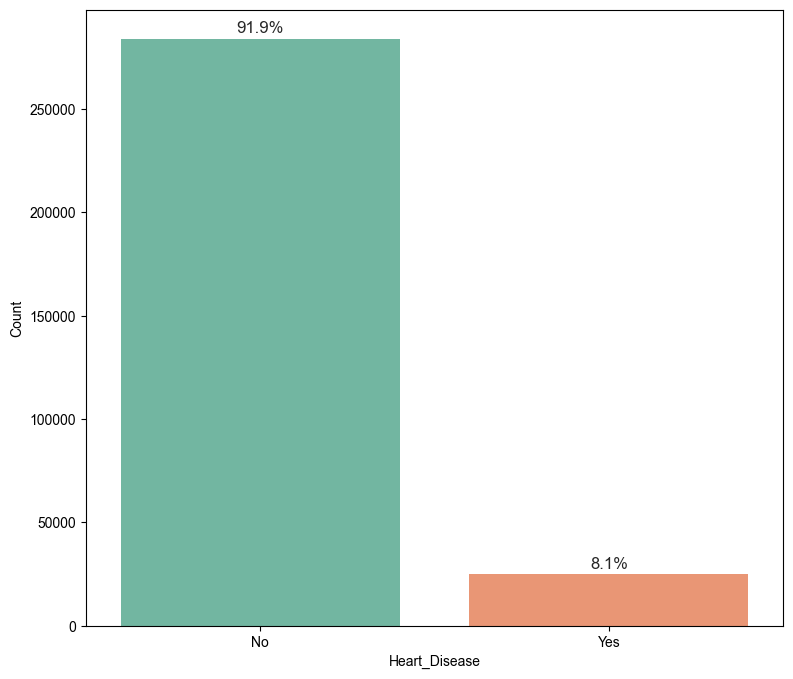

In [8]:
fig, ax = plt.subplots(figsize=(9, 8))

# Assign 'x' variable to 'hue' and set 'legend' to 'False'
ax = sns.countplot(x=target,
                   data=df,
                   hue=target,  # Assign 'x' variable to 'hue'
                   palette='Set2',
                   order=df[target].value_counts().index,
                   legend=False  # Set legend to False
                   )

sns.set(font='Arial')


ax.set_ylabel('Count')

patches = ax.patches

for j in range(len(patches)):
    percentage = list(df[target].value_counts())[j] / df[target].value_counts().sum()
    offset = df[target].value_counts().max() * 0.01
    x = patches[j].get_x() + patches[j].get_width() / 2
    y = patches[j].get_height() + offset
    ax.annotate('{:.1f}%'.format(percentage * 100), (x, y), ha='center')

plt.show()


- We can deduct from this that the target variable is imbalanced.

### Univariate Analysis

General_Health


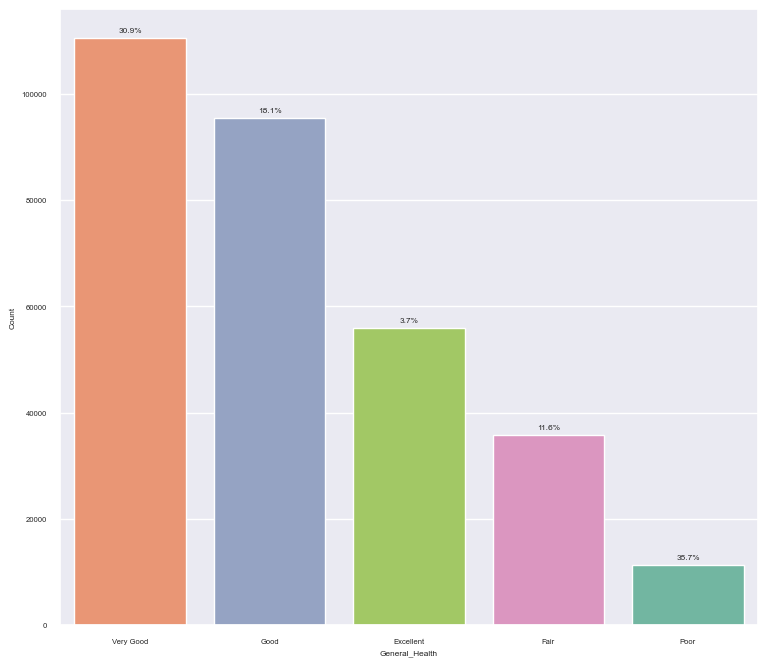

Checkup


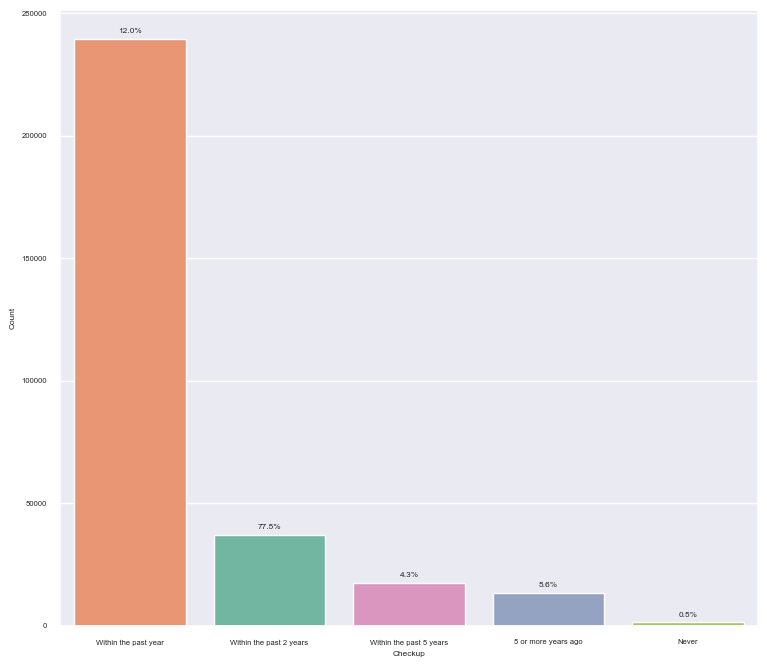

Exercise


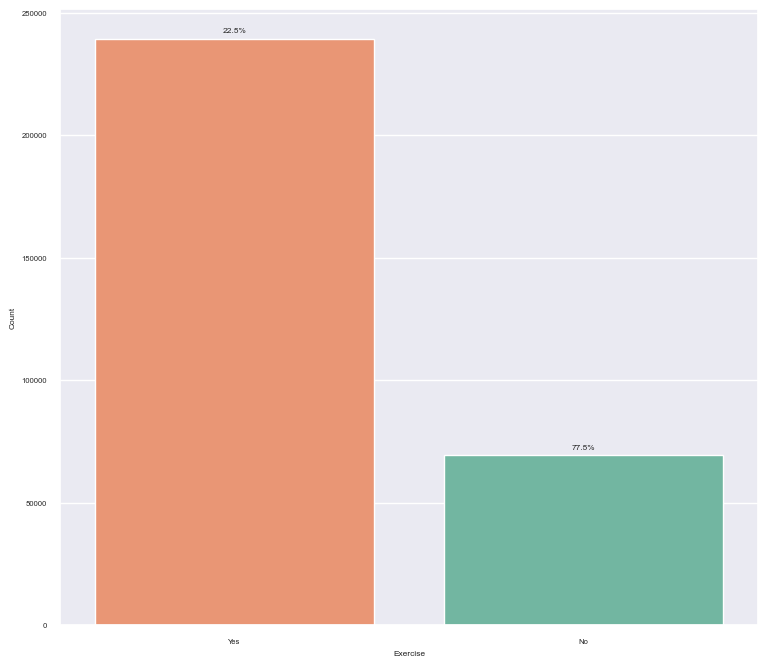

Skin_Cancer


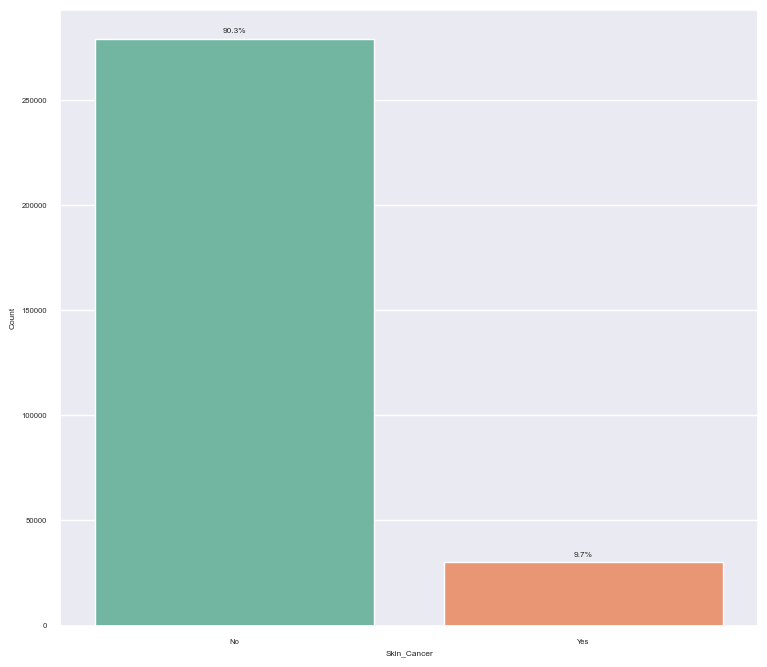

Other_Cancer


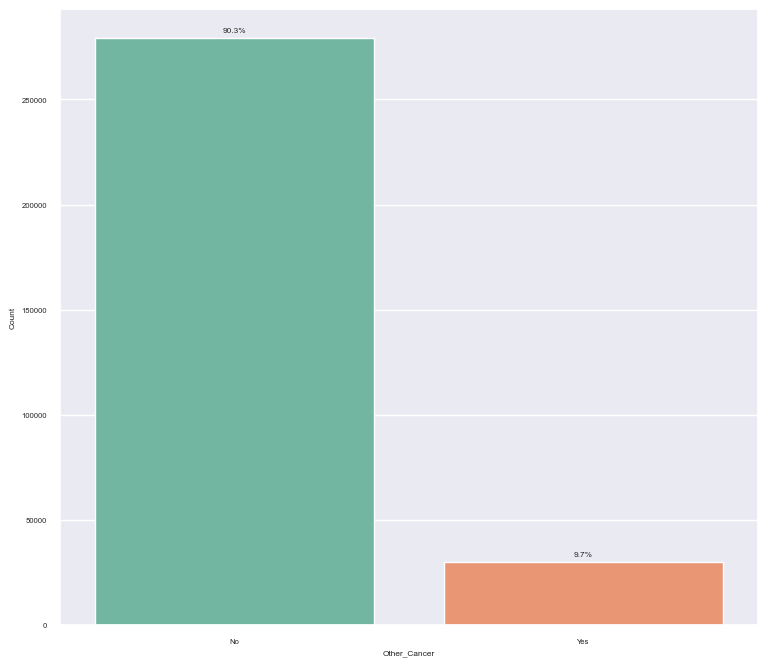

Depression


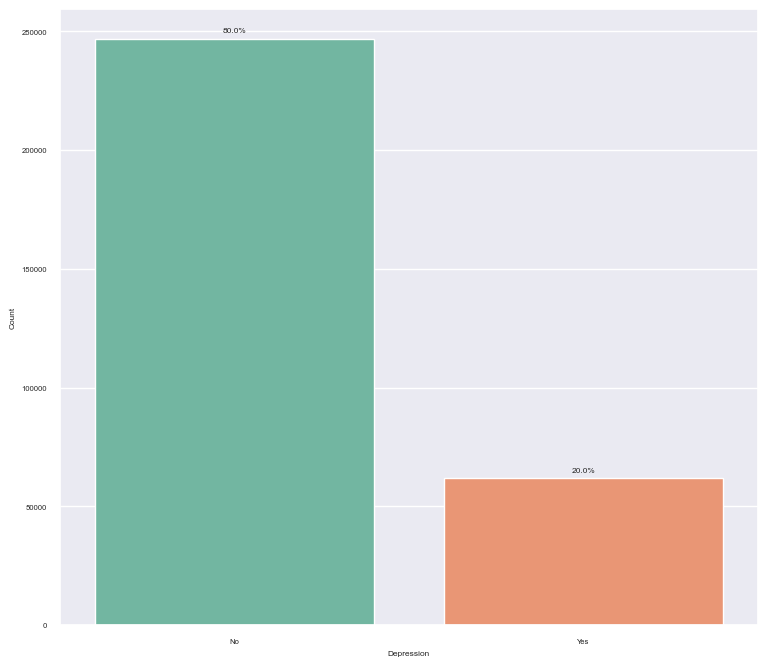

Diabetes


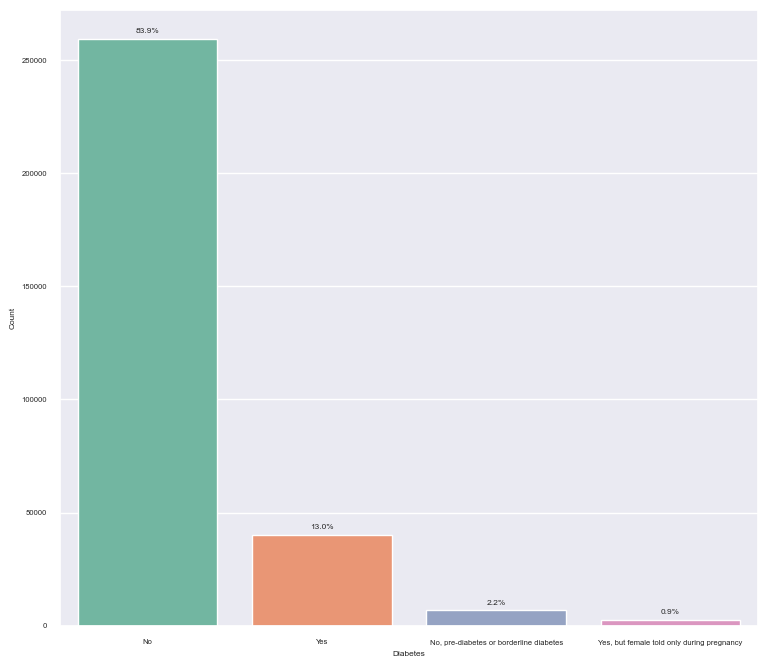

Arthritis


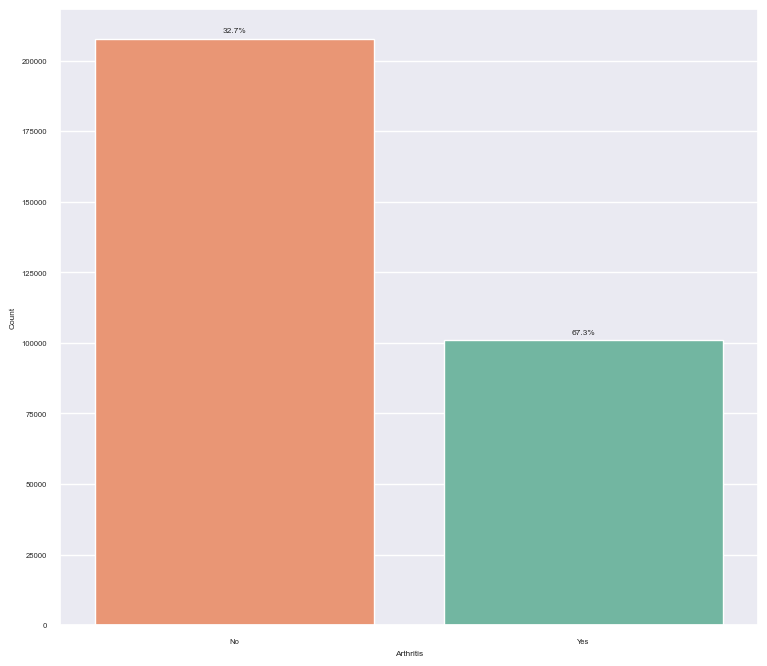

Sex


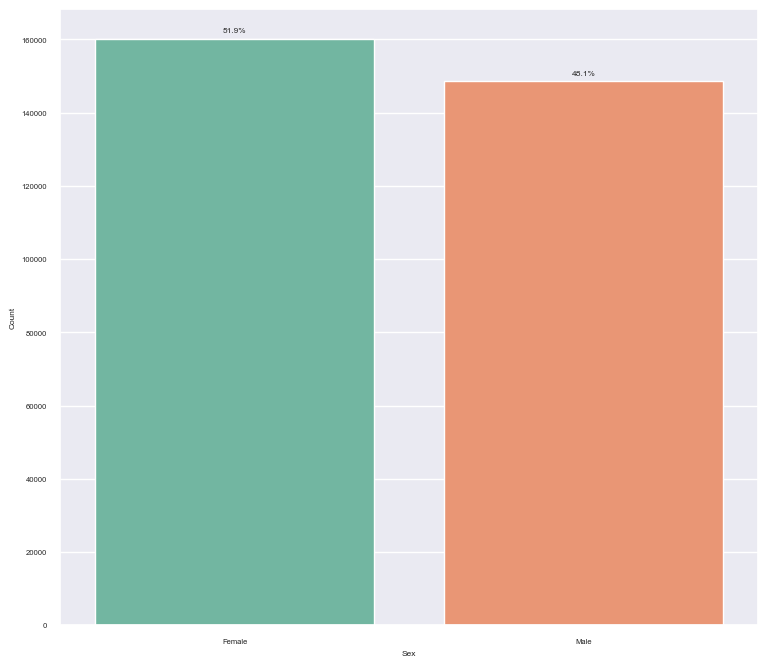

Age_Category


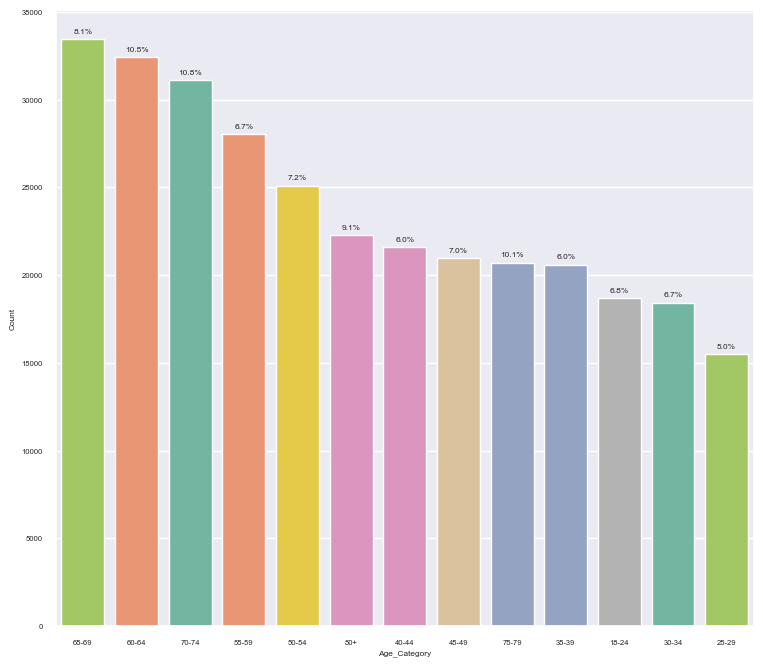

Height_(cm)


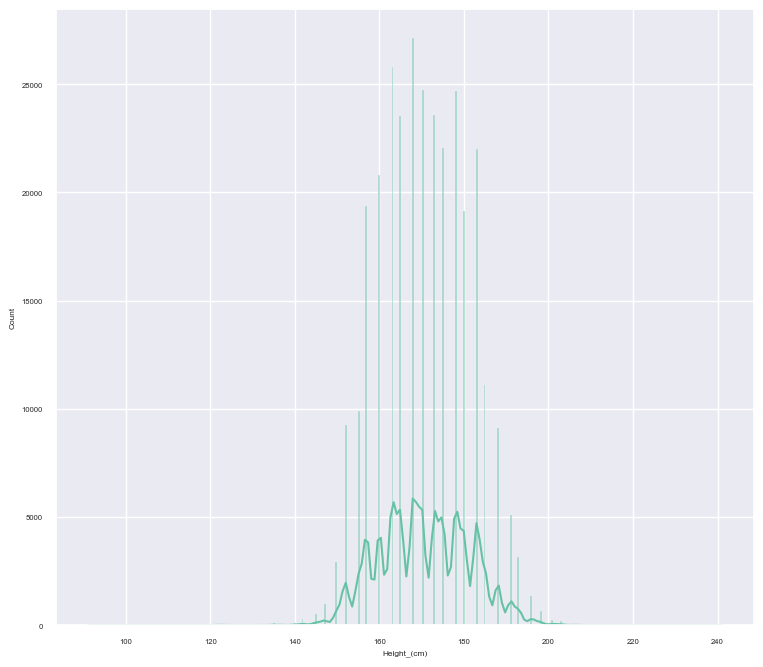

Weight_(kg)


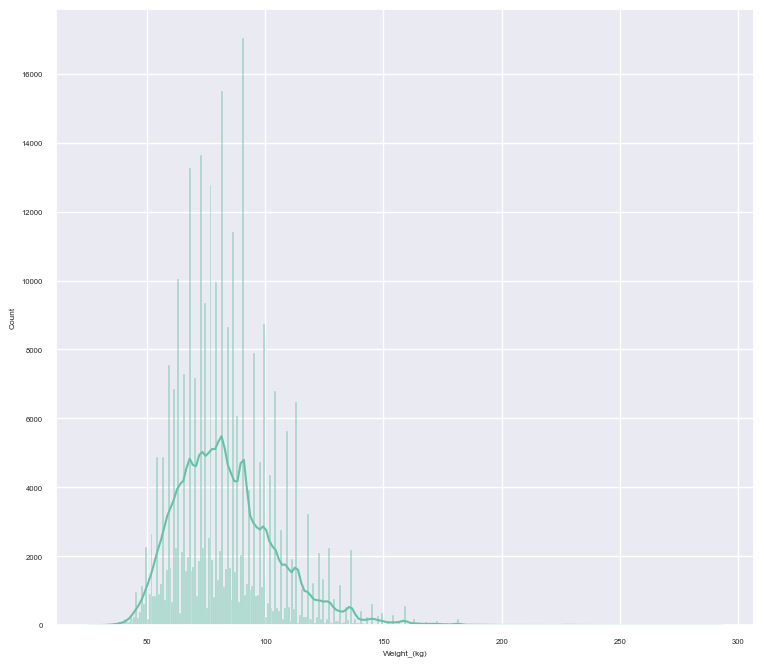

BMI


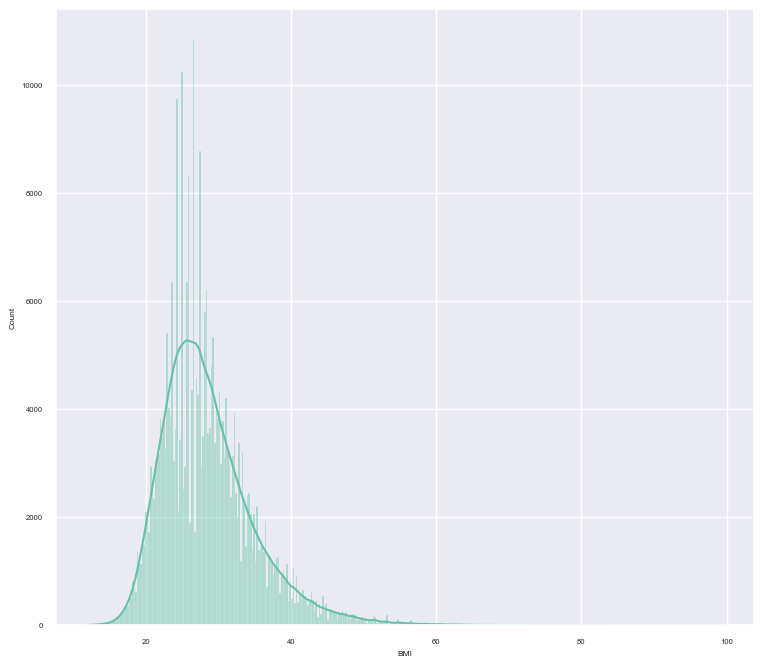

Smoking_History


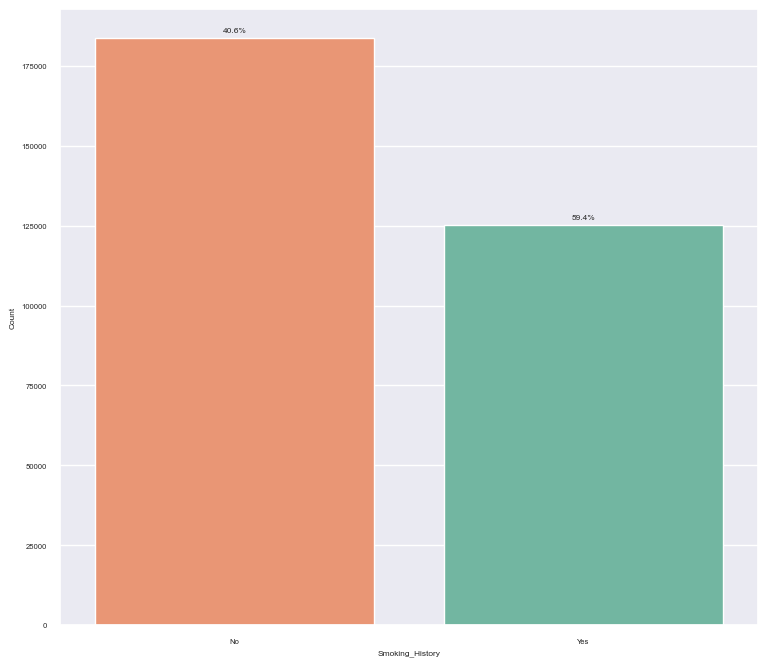

Alcohol_Consumption


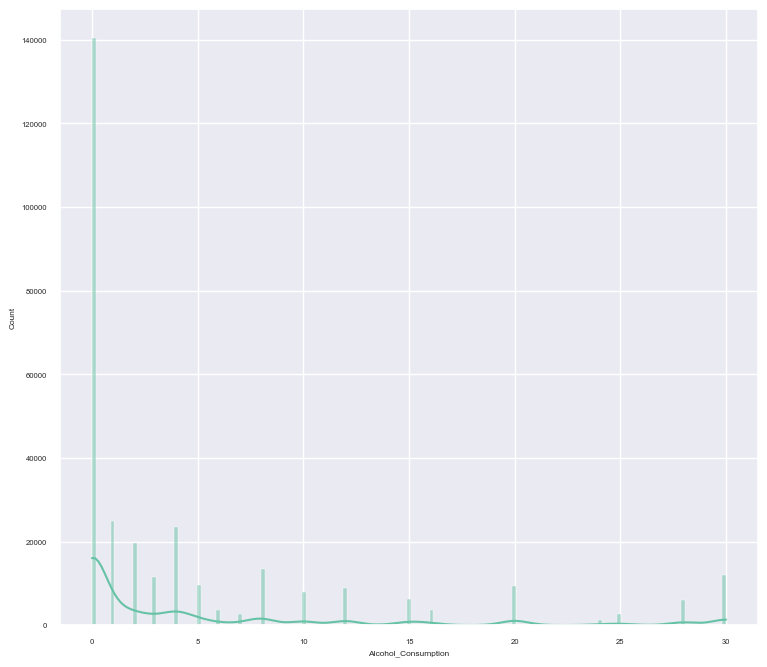

Fruit_Consumption


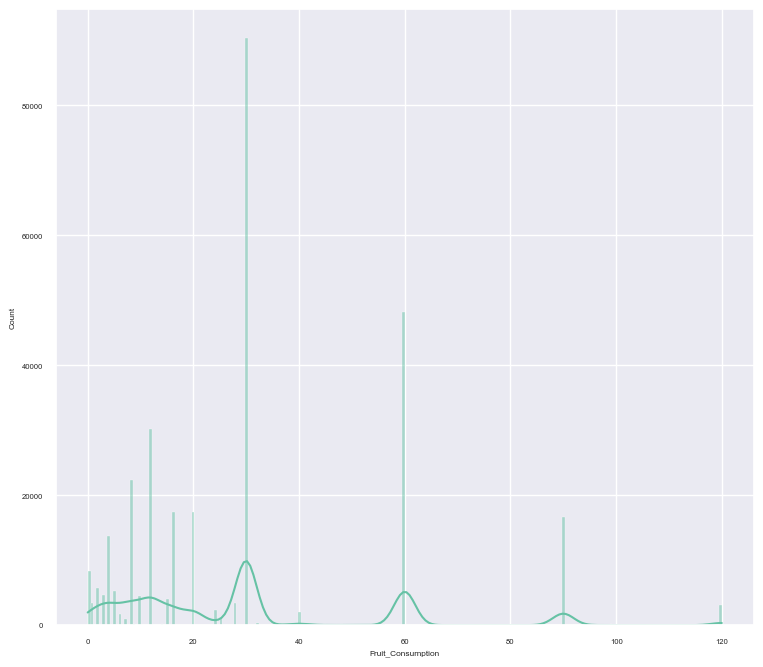

Green_Vegetables_Consumption


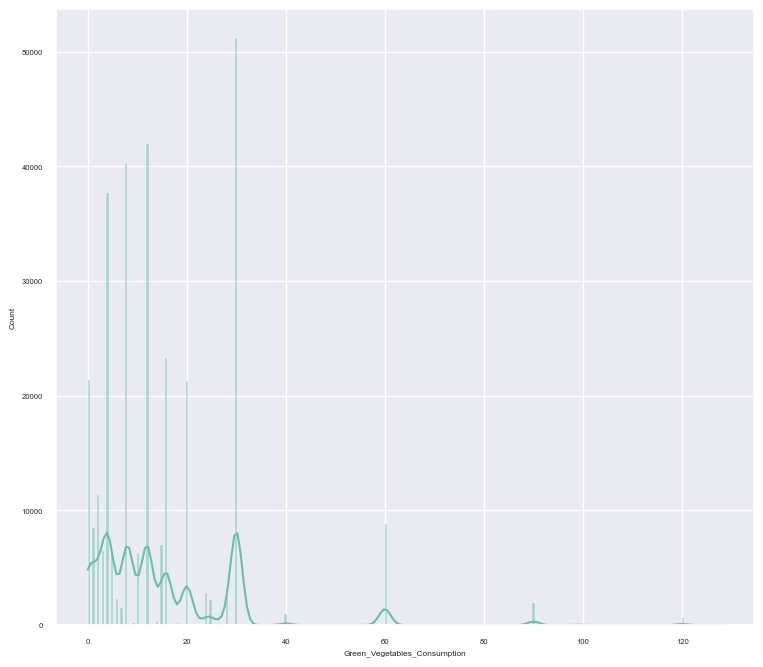

FriedPotato_Consumption


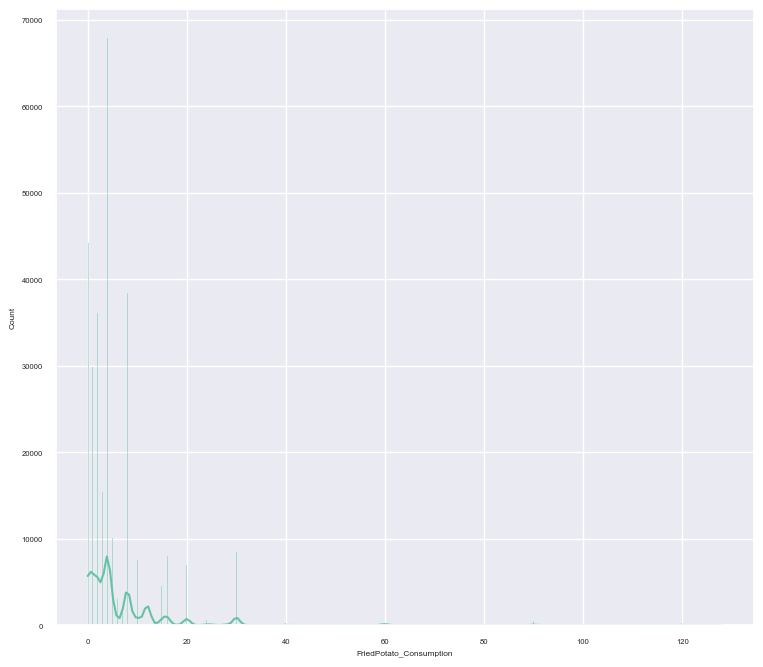

In [9]:
sns.set(font_scale=0.5)

for i in df.columns:
    if i == target:
        continue

    if i in categorical:
        if df[i].nunique() > 15:
            print(f'column {i} has many unique values n = {df[i].nunique()} and will not be plotted')
            print('=======================================================')
            continue
        else:
            print(f'{i}')
            fig, ax = plt.subplots(figsize=(9, 8))
            color = 'Set2'
            palette_color = sns.color_palette(color)
            
            # Assign 'x' variable to 'hue' and set 'legend' to 'False'
            ax = sns.countplot(x=i,
                data=df,
                hue=i,  # Assign 'x' variable to 'hue'
                palette=color,
                order=df[i].value_counts().index,
                legend=False  # Set legend to False
            )
            ax.set_ylabel('Count')

            patches = ax.patches

            for j in range(len(patches)):
                offset = df[i].value_counts().max() * 0.01
                percentage = list(df[i].value_counts())[j] / df[i].value_counts().sum()
                x = patches[j].get_x() + patches[j].get_width() / 2
                y = patches[j].get_height() + offset
                ax.annotate('{:.1f}%'.format(percentage * 100), (x, y), ha='center')

            plt.show()
            print('=======================================================')

    elif i in numerical:
        print(f'{i}')
        fig, ax = plt.subplots(figsize=(9, 8))
        color = 'Set2'
        palette_color = sns.color_palette(color)
        ax = sns.histplot(x=i,
            data=df,
            kde=True,
            color=palette_color[0],
        )
        ax.set_ylabel('Count')
        plt.show()
        print('=======================================================')

### Bivariate Analysis for Classification

#### Categorical

Age_Category vs. Heart_Disease


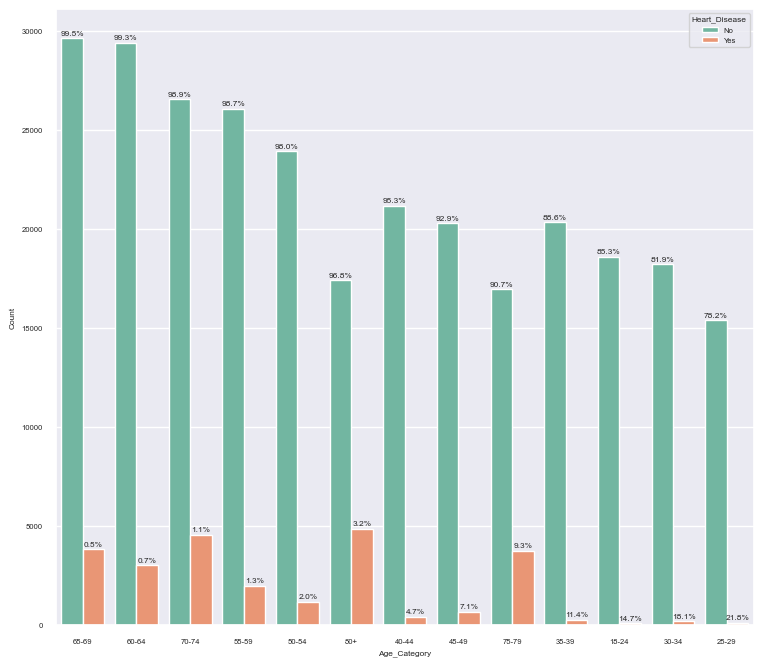

Arthritis vs. Heart_Disease


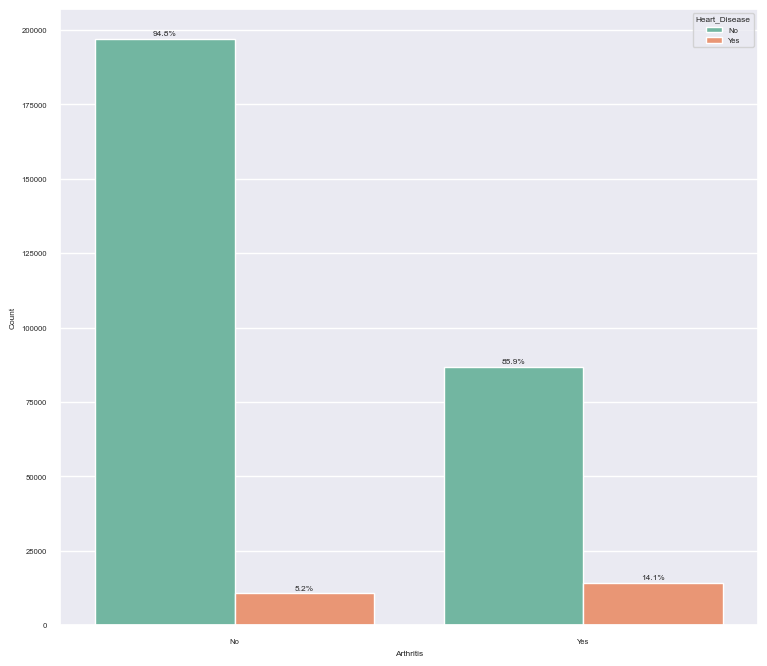

Checkup vs. Heart_Disease


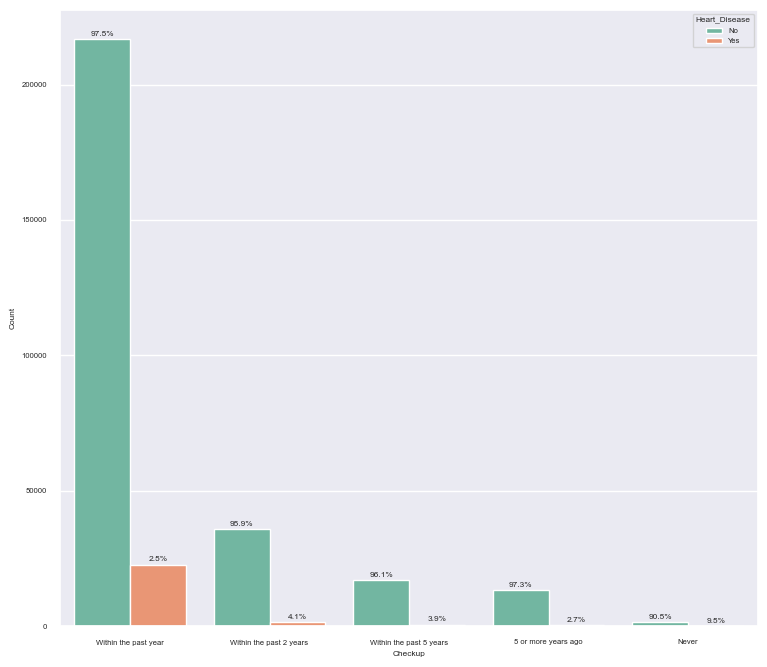

Depression vs. Heart_Disease


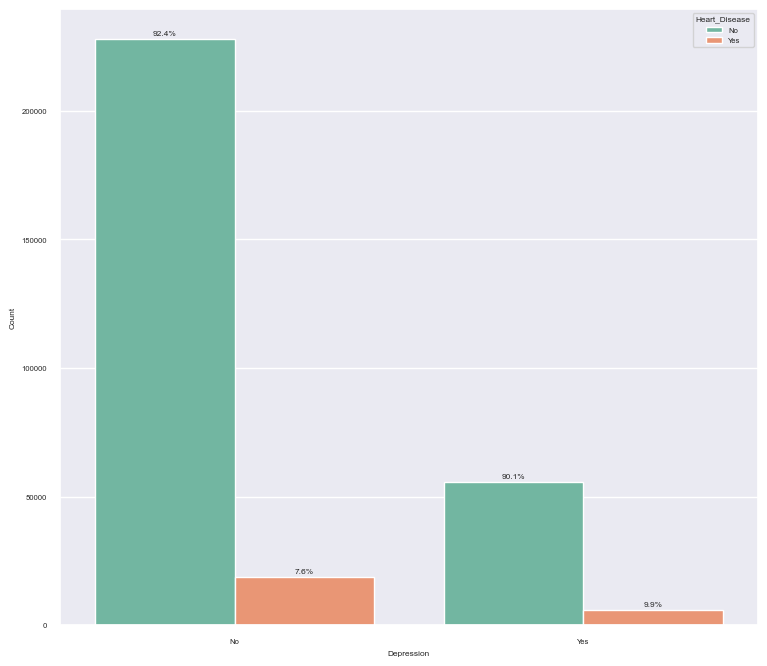

Diabetes vs. Heart_Disease


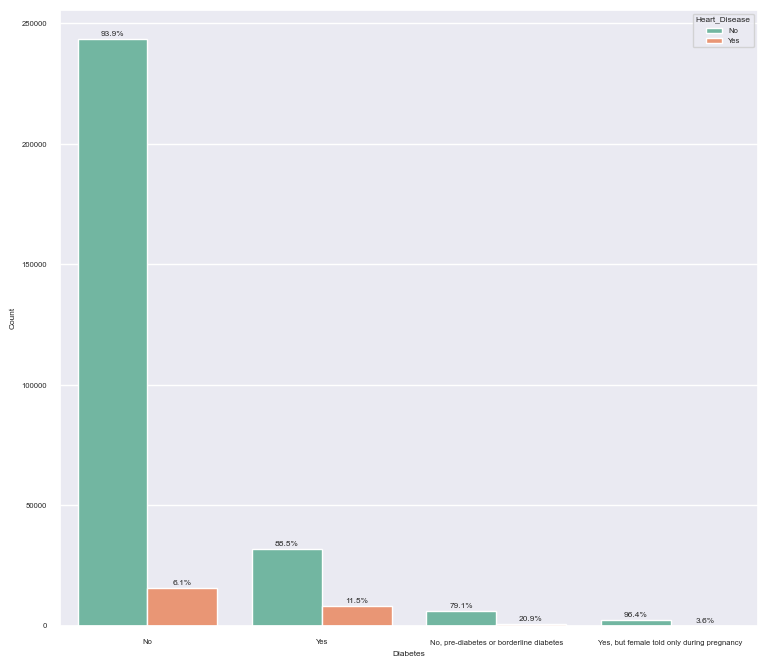

Exercise vs. Heart_Disease


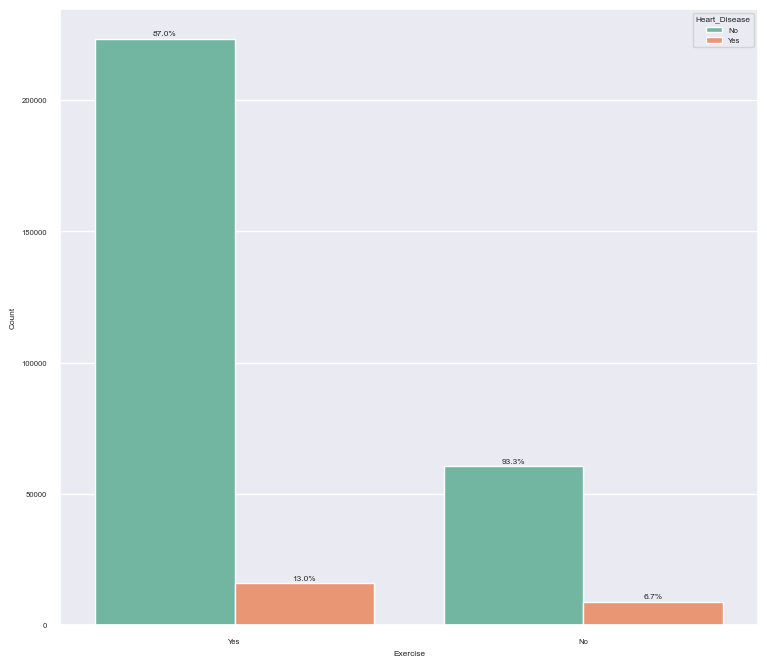

General_Health vs. Heart_Disease


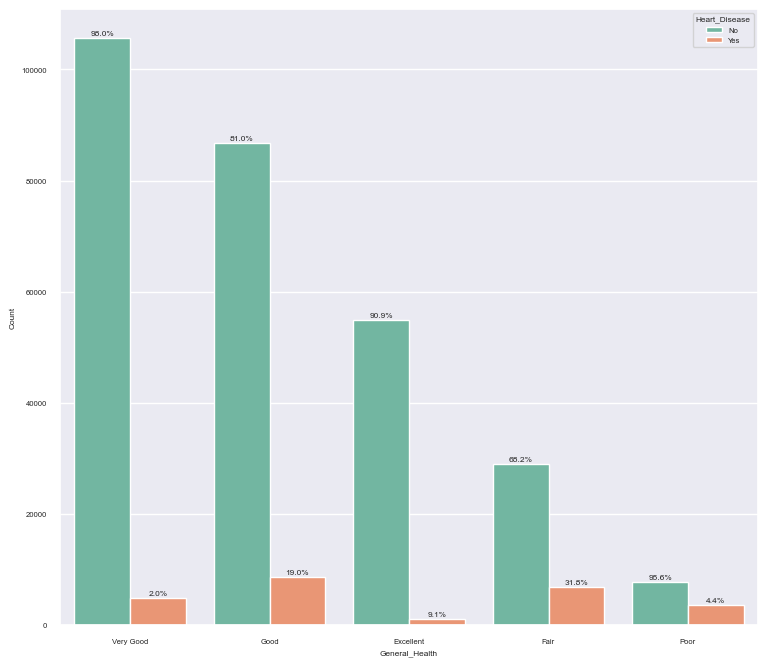

Other_Cancer vs. Heart_Disease


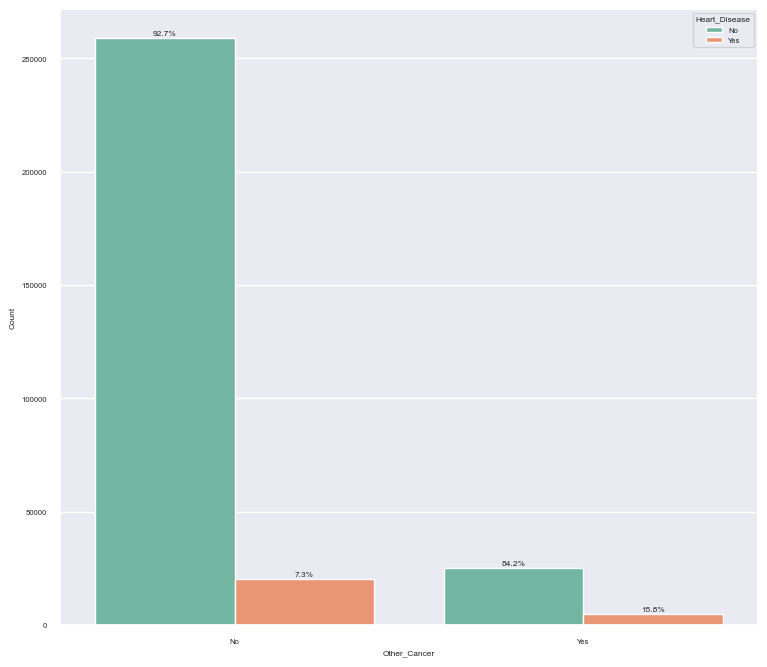

Sex vs. Heart_Disease


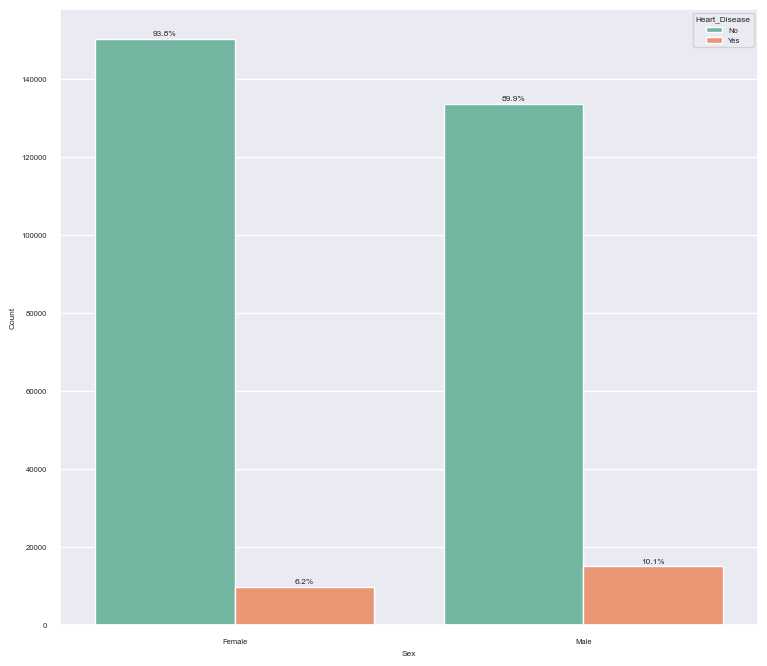

Skin_Cancer vs. Heart_Disease


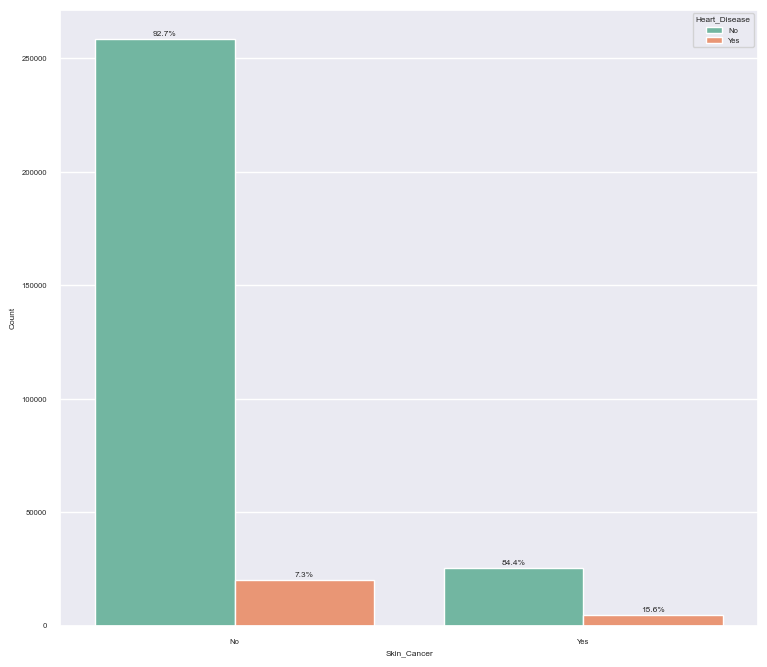

Smoking_History vs. Heart_Disease


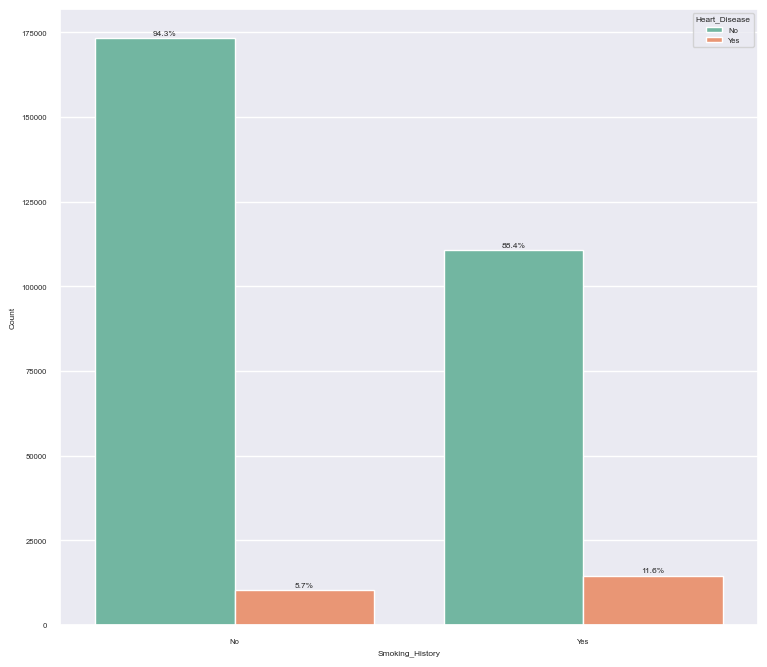

In [10]:
for i in categorical:
        if i == target:
            continue

        if df[i].nunique() > 15:
            print(f'column {i} has many unique values n = {df[i].nunique()} and will not be plotted')
            print('=======================================================')
            continue

        if i in df.columns:
            print(f'{i} vs. {target}')
            eda_bivariate_categorical(df,i,target)
            print('=======================================================')

#### Multivariate Analysis

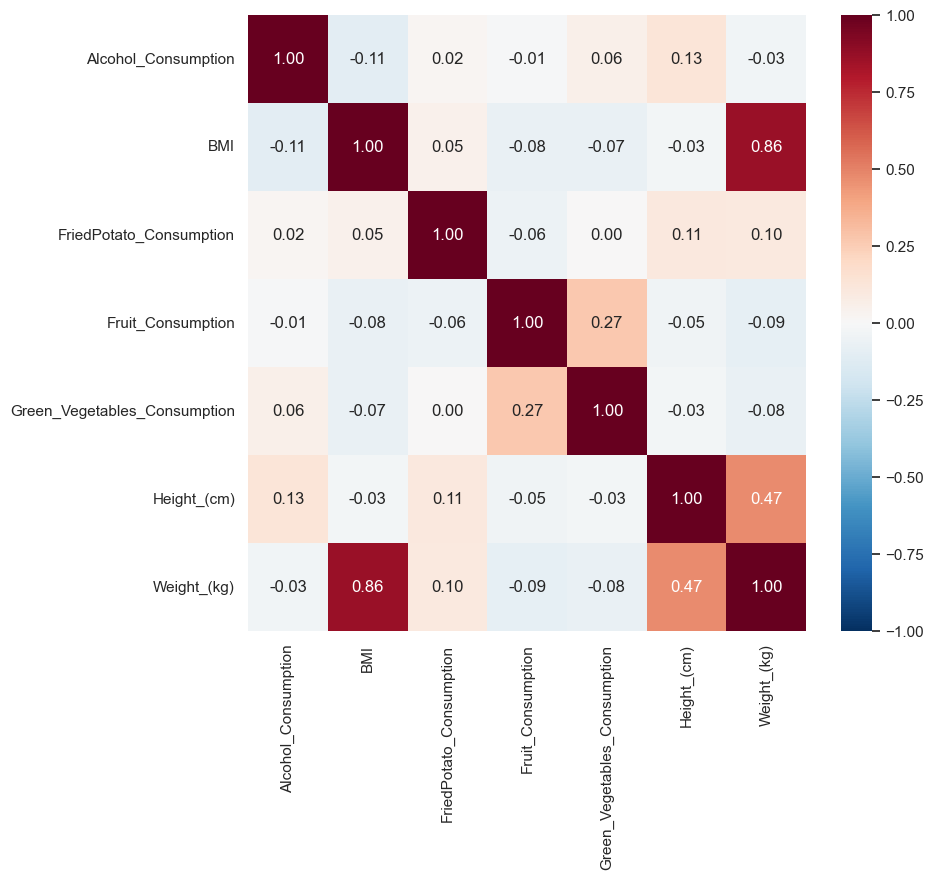

In [11]:
## Plotting the correlation matrix
correlation_matrix = df[numerical].corr()
plt.figure(figsize=(9,8))

sns.set(font_scale=1)

## use mask to cover the upper diagonal in the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix,
            cmap='RdBu_r',
            # cmap='RdYlGn',
            annot=True,
            # Masking the diagonal
            # mask=mask,
            fmt='.2f',
            vmin=-1, vmax=1)

plt.show()

# Feature Engineering (Preprocessing)

Changing the values of Heart Disease to 0 and 1 for preprocessing steps

In [12]:
df['Heart_Disease'] = df['Heart_Disease'].map({'No':0,'Yes':1})
print('')
print(df['Heart_Disease'].value_counts())


Heart_Disease
0    283883
1     24971
Name: count, dtype: int64


Splitting the train and test set. Using stratify to keep the ratio between two classes be the same

In [13]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df, test_size=0.2,random_state=22,stratify=df['Heart_Disease'])

print(train.shape)
print(test.shape)

(247083, 19)
(61771, 19)


Showing the ratio of the target variable from train and test set

In [14]:
yes = train['Heart_Disease'].value_counts()[0]/len(train['Heart_Disease'])*100
no = train['Heart_Disease'].value_counts()[1]/len(train['Heart_Disease'])*100
print('Train Set')
print(f'ratio of people with heart disease to total is {yes}')
print(f'ratio of people that dont have heart disease to total is {no}')
print('')

yes = test['Heart_Disease'].value_counts()[0]/len(test['Heart_Disease'])*100
no = test['Heart_Disease'].value_counts()[1]/len(test['Heart_Disease'])*100
print('Test Set')
print(f'ratio of people with heart disease to total is {yes}')
print(f'ratio of people that dont have heart disease to total is {no}')

Train Set
ratio of people with heart disease to total is 91.91486261701533
ratio of people that dont have heart disease to total is 8.085137382984666

Test Set
ratio of people with heart disease to total is 91.91530005989866
ratio of people that dont have heart disease to total is 8.084699940101341


In [15]:
## Splitting the X and y variables in the train set
X_train = train.drop("Heart_Disease", axis=1)
y_train = train["Heart_Disease"].copy()

## Splitting the X and y variables in the test set
X_test = test.drop("Heart_Disease", axis=1)
y_test = test["Heart_Disease"].copy()

Printing the number of unique values per each column

In [16]:
X_train.nunique()

General_Health                     5
Checkup                            5
Exercise                           2
Skin_Cancer                        2
Other_Cancer                       2
Depression                         2
Diabetes                           4
Arthritis                          2
Sex                                2
Age_Category                      13
Height_(cm)                       98
Weight_(kg)                      502
BMI                             3502
Smoking_History                    2
Alcohol_Consumption               31
Fruit_Consumption                 73
Green_Vegetables_Consumption      73
FriedPotato_Consumption           67
dtype: int64

Notes:
* There are 8 categorical variables. Variables that are not in order.
* There are 7 numerical variables.
* There are 3 ordinal variables. The General Health, Age Category, and the Checkup variable, The data from this can be represented with an order.

# Creating Pipelines

## Categorical Pipeline

In [17]:
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore',drop='first'))

* For categorical pipeline, only OneHotEncoder will be implemented. Since this dataset has been cleaned and there are no missing values.

## Numerical Pipeline

In [18]:
num_pipeline = make_pipeline(
                             FunctionTransformer(np.log1p,feature_names_out='one-to-one'),
                             StandardScaler()
                            )

For numerical pipeline, two methods are used:
1. Log Transform: From the EDA, most of the numerical functions are skewed right.
2. Standard Scaler: The numerical variable will be scaled to put them all on the same scale.

## Ordinal Pipeline

In [19]:
## Age Category Pipeline
agecat_pipeline = make_pipeline(
        OrdinalEncoder()
)

## General Health Pipeline
genhealth_pipeline = make_pipeline(
        OrdinalEncoder(categories=[['Poor','Fair','Good','Very Good','Excellent']])
)

## Checkup Pipeline
checkup_pipeline = make_pipeline(
        OrdinalEncoder(categories=[['Within the past year','Within the past 2 years','Within the past 5 years','5 or more years ago','Never']])
)

* For the ordinal variable, the variables are transformed based on their order. The values with in the lowest order will start with 0 and increases by 1.

## Creating the pipeline lists

In [20]:
## Setting each column to the pipeline where they will be used
num_pipe_col = numerical

cat_pipe_col = ['Arthritis', 'Depression', 'Diabetes',
       'Exercise', 'Other_Cancer', 'Sex',
       'Skin_Cancer', 'Smoking_History']

## Finalizing the preprocessing pipeline

In [21]:
## Combining all the pipelines and creating a main pipeline to enter all the data
preprocessing = ColumnTransformer([
    ('Categorical', cat_pipeline,   cat_pipe_col),
    ('Age_Category',agecat_pipeline,['Age_Category']),
    ('Checkup',checkup_pipeline,['Checkup']),
    ('Gen_health',genhealth_pipeline,['General_Health']),
    ('Numerical',   num_pipeline,  num_pipe_col),
],remainder='passthrough')
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Arthritis', 'Depression', 'Diabetes',
                                  'Exercise', 'Other_Cancer', 'Sex',
                                  'Skin_Cancer', 'Smoking_History']),
                                ('Age_Category',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['Age_Category']),...
                                                                              'Excellent']]))]),
                                 ['General_Health']),
                                ('Numerical',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Alcohol_Consumption', 'BMI', 'FriedPotato_Consumption',
       'Fruit_Consumption', 'Green_Vegetables_Consumption', 'Height_(cm)',
       'Weight_(kg)'],
      dtype='object'))])

In [22]:
## Using preprocessing pipeline
print('Shape before the preprocessing:')
print(X_train.shape)

train_preprocessed = preprocessing.fit_transform(X_train)

print('Shape after the preprocessing:')
print(train_preprocessed.shape)

Shape before the preprocessing:
(247083, 18)


Shape after the preprocessing:
(247083, 20)


In [23]:
train_preprocessed[:5]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.00000000e+00,  0.00000000e+00,
         4.00000000e+00,  1.87007552e+00, -1.52461967e+00,
        -4.87091678e-01,  6.13004916e-03, -9.53748411e-01,
        -2.13824879e-01, -1.45449652e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.20000000e+01,  0.00000000e+00,
         3.00000000e+00, -9.10705045e-01, -7.75562687e-01,
        -1.66354705e+00, -2.04183373e-01, -7.34162436e-01,
         8.86072283e-01, -2.05255774e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  9.0

# Feature Selection (Recursive Feature Elimination)

## Define the RFE Model

In [24]:
# Define the RFE model with a classifier (e.g., RandomForestClassifier)
rfe_model = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)

## Fit the RFE Model to the Training Data

In [25]:
# Fit the RFE model to your training data
X_train_rfe = rfe_model.fit_transform(train_preprocessed, y_train)

## Print the Ranking of Features Based on Importance

In [26]:
# Print the ranking of features based on importance
print("Feature Rankings:")
for feature, rank in zip(X_train.columns, rfe_model.ranking_):
    print(f"Feature: {feature}, Rank: {rank}")

Feature Rankings:
Feature: General_Health, Rank: 7
Feature: Checkup, Rank: 8
Feature: Exercise, Rank: 15
Feature: Skin_Cancer, Rank: 6
Feature: Other_Cancer, Rank: 16
Feature: Depression, Rank: 9
Feature: Diabetes, Rank: 11
Feature: Arthritis, Rank: 14
Feature: Sex, Rank: 13
Feature: Age_Category, Rank: 12
Feature: Height_(cm), Rank: 2
Feature: Weight_(kg), Rank: 10
Feature: BMI, Rank: 4
Feature: Smoking_History, Rank: 5
Feature: Alcohol_Consumption, Rank: 1
Feature: Fruit_Consumption, Rank: 1
Feature: Green_Vegetables_Consumption, Rank: 1
Feature: FriedPotato_Consumption, Rank: 1


## Print the List of Selected Features

In [27]:
# Print the list of selected features
selected_features = pd.DataFrame(train_preprocessed).columns[rfe_model.support_]
print("Selected Features:")
print(selected_features)

Selected Features:
Index([14, 15, 16, 17, 19], dtype='int64')


# Model Development

## Defining the MLP Model

In [50]:
mlp_model_rfe = MLPClassifier(hidden_layer_sizes=(200, 100), max_iter=1, warm_start=True, random_state=42)

## Define the number of iterations

In [51]:
# Define the number of iterations
max_iterations = 10000

## Initialise Lists to Store Evaluation Metrics After Each Iteration

In [53]:
# Initialize lists to store evaluation metrics after each iteration
accuracy_scores = []
precision_scores = []
recall_scores = []
roc_auc_scores = []
confusion_matrices = []
loss_scores = []

## Plot/Output Training Progress

In [54]:
for iteration in range(max_iterations):
    mlp_model_rfe.partial_fit(train_preprocessed, y_train, classes=np.unique(y_train))

    # After each iteration, evaluate the model
    y_pred = mlp_model_rfe.predict(train_preprocessed)

    # Calculate loss
    loss = mlp_model_rfe.loss_
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    fpr, tpr, _ = roc_curve(y_train, y_pred)
    auc_roc = auc(fpr, tpr)
    confusion = confusion_matrix(y_train, y_pred)

    # Append metrics to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    roc_auc_scores.append(auc_roc)
    confusion_matrices.append(confusion)
    loss_scores.append(loss)  # Append loss value to the list

    print(f'Iteration {iteration + 1}/{max_iterations} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC ROC: {auc_roc:.4f}, Loss: {loss:.4f}')

Iteration 1/10000 - Accuracy: 0.9177, Precision: 0.4648, Recall: 0.1203, AUC ROC: 0.5541, Loss: 0.2303
Iteration 2/10000 - Accuracy: 0.9194, Precision: 0.6079, Recall: 0.0100, AUC ROC: 0.5047, Loss: 0.2229
Iteration 3/10000 - Accuracy: 0.9194, Precision: 0.6006, Recall: 0.0093, AUC ROC: 0.5044, Loss: 0.2218
Iteration 4/10000 - Accuracy: 0.9195, Precision: 0.6035, Recall: 0.0139, AUC ROC: 0.5065, Loss: 0.2212
Iteration 5/10000 - Accuracy: 0.9196, Precision: 0.5961, Recall: 0.0183, AUC ROC: 0.5086, Loss: 0.2208
Iteration 6/10000 - Accuracy: 0.9197, Precision: 0.5948, Recall: 0.0204, AUC ROC: 0.5096, Loss: 0.2204
Iteration 7/10000 - Accuracy: 0.9197, Precision: 0.5951, Recall: 0.0207, AUC ROC: 0.5097, Loss: 0.2202
Iteration 8/10000 - Accuracy: 0.9197, Precision: 0.5966, Recall: 0.0209, AUC ROC: 0.5098, Loss: 0.2199
Iteration 9/10000 - Accuracy: 0.9197, Precision: 0.5973, Recall: 0.0201, AUC ROC: 0.5095, Loss: 0.2195
Iteration 10/10000 - Accuracy: 0.9197, Precision: 0.5908, Recall: 0.0231,

# Model Validation

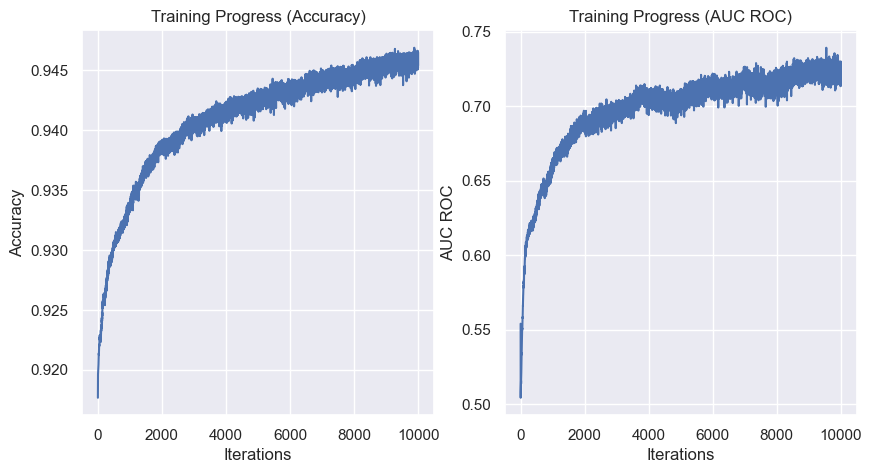

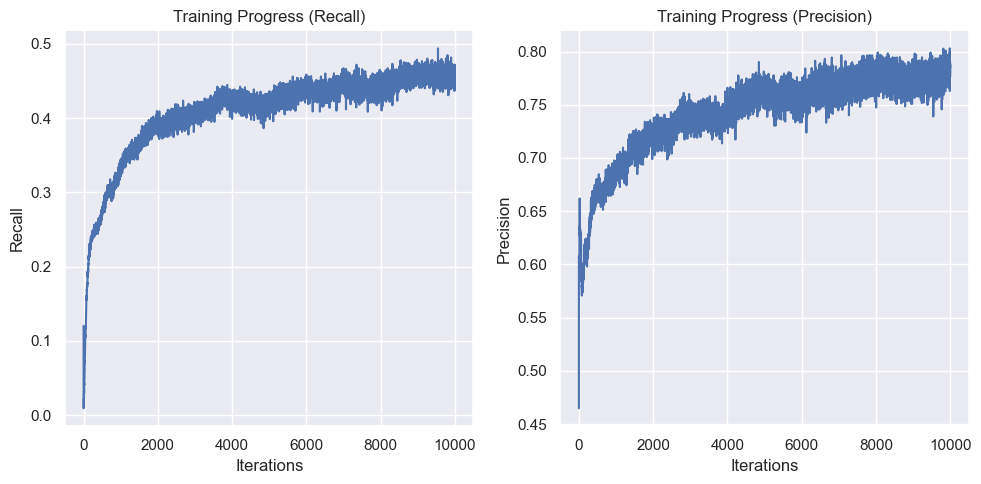


Final Evaluation Metrics with RFE:
Accuracy: 0.9465
Precision: 0.7846
Recall: 0.4661
AUC ROC: 0.7274

Confusion Matrix:
[[224550   2556]
 [ 10665   9312]]


In [55]:
# Plot the training progress for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_iterations + 1), accuracy_scores)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Progress (Accuracy)')

# Plot the training progress for AUC ROC
plt.subplot(1, 2, 2)
plt.plot(range(1, max_iterations + 1), roc_auc_scores)
plt.xlabel('Iterations')
plt.ylabel('AUC ROC')
plt.title('Training Progress (AUC ROC)')

# Plot the training progress for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_iterations + 1), recall_scores)
plt.xlabel('Iterations')
plt.ylabel('Recall')
plt.title('Training Progress (Recall)')

# Plot the training progress for AUC ROC
plt.subplot(1, 2, 2)
plt.plot(range(1, max_iterations + 1), precision_scores)
plt.xlabel('Iterations')
plt.ylabel('Precision')
plt.title('Training Progress (Precision)')

plt.tight_layout()
plt.show()

# Display the final evaluation metrics and confusion matrix
final_iteration = max_iterations - 1
print('\nFinal Evaluation Metrics with RFE:')
print(f'Accuracy: {accuracy_scores[final_iteration]:.4f}')
print(f'Precision: {precision_scores[final_iteration]:.4f}')
print(f'Recall: {recall_scores[final_iteration]:.4f}')
print(f'AUC ROC: {roc_auc_scores[final_iteration]:.4f}')
print('\nConfusion Matrix:')
print(confusion_matrices[final_iteration])

# Saving the Model

In [56]:
# Save the trained MLP model with RFE-selected features
with open('mlp_model_rfe-final.pkl', 'wb') as file:
    pickle.dump(mlp_model_rfe, file)